In [1]:
# imports

# data manipulation
import pandas as pd
import numpy as np

# visualiation
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

# model training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# classifiers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.tree import DecisionTreeClassifier # decision tree
from sklearn.ensemble import RandomForestClassifier # random forest
from sklearn.ensemble import GradientBoostingClassifier # gradient boosting

In [2]:
# load data
train_file = './data/train.csv'
train_data = pd.read_csv(train_file)
train_data = pd.DataFrame(data=train_data)

test_file = './data/test.csv'
test_data = pd.read_csv(test_file)
test_data = pd.DataFrame(data=test_data)

test_ground_truths_file = './test_ground_truths.csv'
test_ground_truths = pd.read_csv(test_ground_truths_file)
test_ground_truths = pd.DataFrame(data=test_ground_truths)

test_data['exceeds50K'] = test_ground_truths

In [3]:
# categorical
def preprocess(data):
    preprocessed_data = data.copy()
    
    # too many categories, drop for now
    preprocessed_data = preprocessed_data.drop(['native-country', 'education'], axis=1)
    preprocessed_data = pd.get_dummies(preprocessed_data)
    
    return preprocessed_data

simple_preprocessed_train_data = preprocess(train_data)
simple_preprocessed_test_data = preprocess(test_data)

x_train = simple_preprocessed_train_data.drop('exceeds50K', axis=1)
#netherlands = np.zeros(x_train.shape[0])
#x_train['native-country_ Holand-Netherlands'] = netherlands
print(x_train.shape)
y_train = simple_preprocessed_train_data['exceeds50K']

x_test = simple_preprocessed_test_data.drop('exceeds50K', axis=1)
print(x_test.shape)
y_test = simple_preprocessed_test_data['exceeds50K']

(24421, 45)
(24421, 45)


In [16]:
# RUN MODELS

#classifiers = [KNeighborsClassifier, LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier]
#classifiers = [LinearDiscriminantAnalysis, GaussianNB, SVC]
classifiers = [GradientBoostingClassifier]
#model_names = ['KNN', 'LR', 'DT', 'RF', 'GBM'] 
#model_names = ['LDA', 'GNB', 'SVC']
model_names = ['GBM']

acc = []
f1 = []
for classifier in classifiers:
    model = classifier().fit(x_train, y_train)
    y_pred = model.predict(x_test)
    f1.append(round(f1_score(y_test, y_pred, average='weighted') * 100, 2))
    acc.append(round(accuracy_score(y_test, y_pred) * 100, 2))
print(f1)
print(acc)

[85.92]
[86.59]


         acc  acc_mean
Model                 
GBM    86.59     86.59
avg    86.59     86.59


          f1  F1_mean
Model                
GBM    85.92    85.92
avg    85.92    85.92


Text(0, 0.5, 'Feature Importance Score')

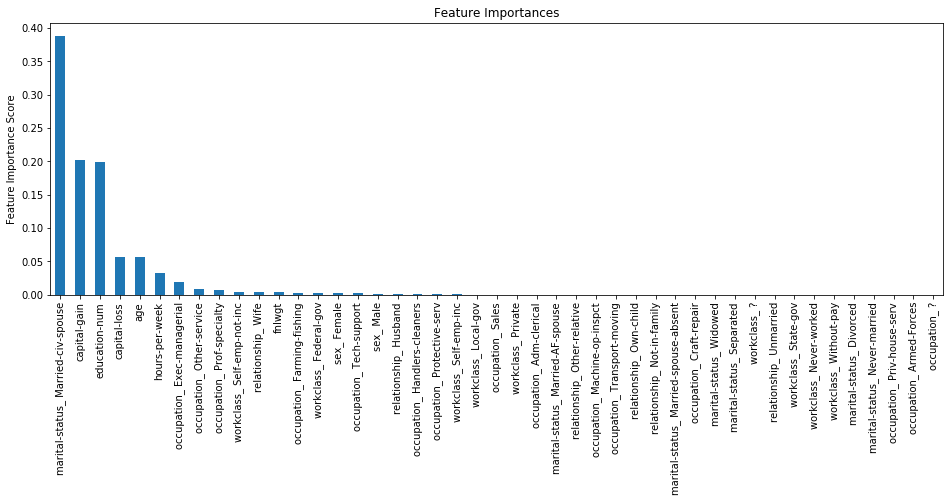

In [17]:
# SHOW RESULTS
accuracy_record = pd.DataFrame({'Model': model_names, 'acc': acc})
accuracy_record['acc_mean'] = accuracy_record.mean(axis=1).round(2)
accuracy_record.set_index('Model', inplace=True)
accuracy_record.loc['avg'] = accuracy_record.mean()

F1_record = pd.DataFrame({'Model': model_names, 'f1': f1})
F1_record['F1_mean'] = F1_record.mean(axis=1).round(2)
F1_record.set_index('Model', inplace=True)
F1_record.loc['avg'] = F1_record.mean()

print(accuracy_record)
print('\n')
print(F1_record)

predictors = [x for x in x_train.columns if x not in ['exceeds50K']]
feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(16,5))
plt.ylabel('Feature Importance Score')

In [22]:
# TUNE HYPERPARAMETERS
classifier = GradientBoostingClassifier()
learning_rate = np.arange(0.3, 2.1, 0.3)
print(learning_rate)
n_estimators = list(range(20,201,20))
print(n_estimators)
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
grid = GridSearchCV(classifier, param_grid=param_grid, cv=10, scoring='accuracy', verbose=True, n_jobs=4)
grid.fit(x_train, y_train)
print(grid.best_params_)
print(grid.best_score_)

[0.3 0.6 0.9 1.2 1.5 1.8]
[20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   21.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  6.2min
[Parallel(n_jobs=4)]: Done 600 out of 600 | elapsed:  9.3min finished


{'learning_rate': 0.3, 'n_estimators': 100}
0.8731829163424921


In [32]:
# TEST TUNED HYPERPARAMETERS
classifier = GradientBoostingClassifier(learning_rate=0.1, n_estimators=350, max_depth=2)
model = classifier.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(round(f1_score(y_test, y_pred, average='weighted') * 100, 2))
print(round(accuracy_score(y_test, y_pred) * 100, 2))

86.42
87.02


In [29]:
# SAVE Y_PRED TO CSV FILE
print(y_pred)
y_pred_file_name = './predictions.csv'
y_pred_file = open(y_pred_file_name, 'w')
output = 'id,prediction\n'
index = 1
for i in y_pred:
    output += str(index)
    output += ','
    output += str(i)
    output += '\n'
    index += 1
y_pred_file.write(output)
y_pred_file.close()
print(index)

[0 0 0 ... 0 0 0]
24422
